In [1]:
from numpy import *
from scipy import signal
from scipy.integrate import quad
import TMQGP as tm
import tqdm.notebook as tqdm
from QuarkTM import Particle, Channel
import QuarkTM
import pickle
import matplotlib

In [2]:
from syntax_sugar import pipe, END
from syntax_sugar import thread_syntax as t, process_syntax as p

NTHR = 14

In [3]:
matplotlib.style.use('publication')

In [126]:
folder = 'output/TestDef_LO_G=(14.50,15.50)L=0.200MQ=0.60MG=1.80screen=0.030/'
# folder = 'output/SuppressGL1HI_Q_G=(14.50,15.50)L=0.200MQ=0.60MG=1.80screen=0.010/'
folderHD = 'output/TestDef_HI_G=(14.50,15.50)L=0.200MQ=0.60MG=1.80screen=0.030/'

In [127]:
T = 0.16

In [128]:
qrange = np.loadtxt(folder + 'qrange_T=%.3f.dat'%T)
erange = np.loadtxt(folder + 'erange_T=%.3f.dat'%T)

qrange_HD = np.loadtxt(folderHD + 'qrange_T=%.3f.dat'%T)
erange_HD = np.loadtxt(folderHD + 'erange_T=%.3f.dat'%T)

In [129]:
Gtab_Q = np.loadtxt(folder + 'Q_G_T=%.3f.dat'%T, dtype=complex)
Gtab_Q_HD = np.loadtxt(folderHD + 'Q_G_T=%.3f.dat'%T, dtype=complex)

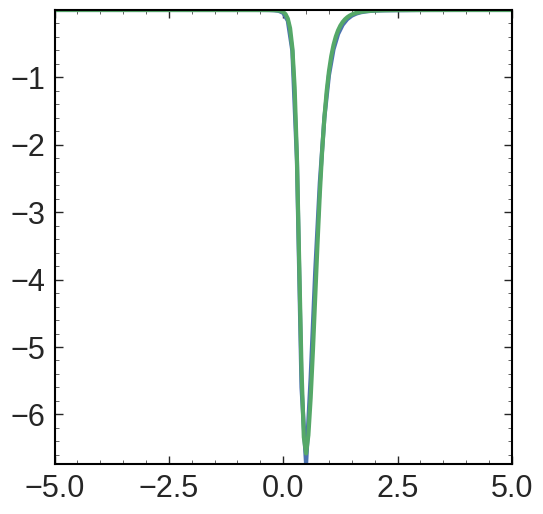

In [130]:
plt.plot(erange, imag(Gtab_Q[:, 0]))
plt.plot(erange_HD, imag(Gtab_Q_HD[:, 0]))

In [131]:
ch = 'qa1'
l = 0

In [132]:
x = np.loadtxt(folder + f'Q_X_{ch}_l=%i_T=%.3f.dat'%(l,T),
                           dtype=complex)

x_HD = np.loadtxt(folderHD + f'Q_X_{ch}_l=%i_T=%.3f.dat'%(l,T),
                           dtype=complex)

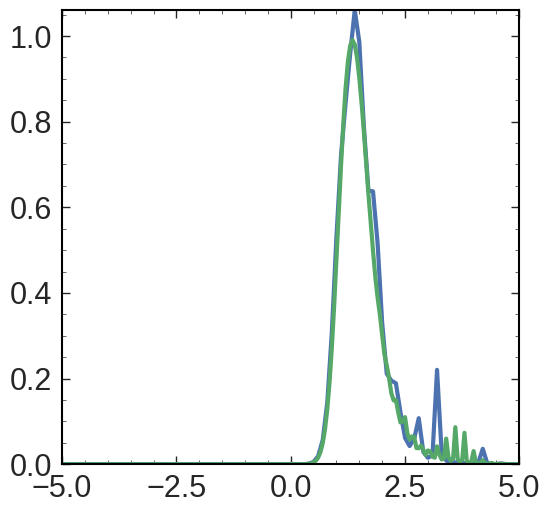

In [133]:
plt.plot(erange, imag(x[:, 0]))
plt.plot(erange_HD, imag(x_HD[:, 0]))

# plt.semilogy()

Single-channel test

In [134]:
l = 0
k = 'qa1'

In [135]:
v = np.loadtxt(folder + f'{k}_vq_l=%i_T=%.3f.dat'%(l, T))
ds, da, Fa = np.loadtxt(folder + f'{k}_weights')

_lt = (2*l + 1) * sign(v[1])*4*pi*ds * da / 6 * v**2 / x * log(1 - x)

In [136]:
v = np.loadtxt(folderHD + f'{k}_vq_l=%i_T=%.3f.dat'%(l, T))
ds, da, Fa = np.loadtxt(folderHD + f'{k}_weights')
_lt_hd = (2*l + 1) * sign(v[1])*4*pi*ds * da / 6 * v**2 / x_HD * log(1 - x_HD)

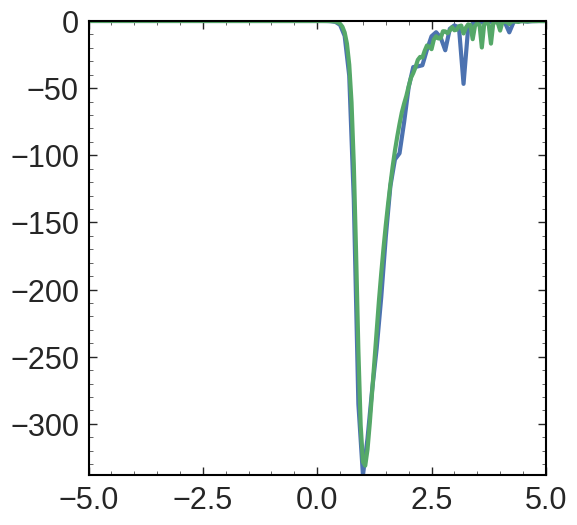

In [137]:
plt.plot(erange, imag(_lt[:, 0]))
plt.plot(erange_HD, imag(_lt_hd[:, 0]))

In [138]:
Gtab_Q = np.loadtxt(folder + 'Q_G_T=%.3f.dat'%T, dtype=complex)
Gtab_Q_HD = np.loadtxt(folderHD + 'Q_G_T=%.3f.dat'%T, dtype=complex)

In [139]:
pQ = QuarkTM.Particle(0.6, qrange, erange, Gtab=Gtab_Q)
pQ_HD = QuarkTM.Particle(0.6, qrange_HD, erange_HD, Gtab=Gtab_Q_HD)

In [140]:
iImLT = tm.Interpolator2D(qrange, erange, ascontiguousarray(imag(_lt)))
iImLT_HD = tm.Interpolator2D(qrange_HD, erange_HD, ascontiguousarray(imag(_lt_hd)))


In [141]:
iEps1 = tm.Interpolator(qrange, pQ.om0(qrange), 'linear')
iEps1_HD = tm.Interpolator(qrange_HD, pQ_HD.om0(qrange_HD), 'linear')

In [142]:
ST = array([
            pipe(erange) | p[lambda z: tm.sigma_ff_onshell(z, q, T, iImLT, pQ.R, 
                                           iEps1, iEps1)] * NTHR | END
                    for q in tqdm.tqdm(qrange)])

  0%|          | 0/21 [00:00<?, ?it/s]

In [143]:
ST = ST.transpose()

In [144]:
ST_HD = array([
            pipe(erange_HD) | p[lambda z: tm.sigma_ff_onshell(z, q, T, iImLT_HD, pQ_HD.R, 
                                           iEps1_HD, iEps1_HD)] * NTHR | END
                    for q in tqdm.tqdm(qrange_HD)])

  0%|          | 0/51 [00:00<?, ?it/s]

In [145]:
ST_HD = ST_HD.transpose()

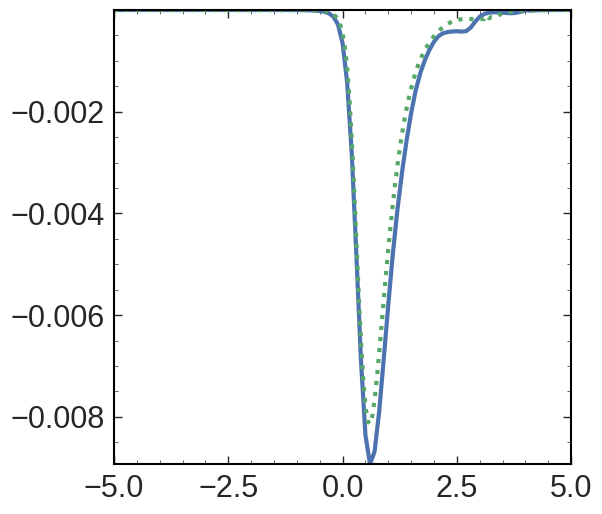

In [146]:
plt.plot(erange, ST[:, 0])
plt.plot(erange_HD, ST_HD[:, 0], ls=':')

## Explore the difference in integration

In [147]:
q = 0

In [148]:
st0 = array([tm.sigma_ff_onshell(z, q, T, iImLT_HD, pQ_HD.R, 
                                           iEps1_HD, iEps1_HD) for z in erange_HD])

In [149]:
st1 = array([tm.sigma_ff_onshell(z, q, T, iImLT_HD, pQ_HD.R, 
                                           iEps1, iEps1) for z in erange_HD])

In [150]:
st0_R = array([tm.sigma_ff_onshell(z, q, T, iImLT_HD, pQ.R, 
                                           iEps1_HD, iEps1_HD) for z in erange_HD])

In [151]:
st0_RE = array([tm.sigma_ff_onshell(z, q, T, iImLT_HD, pQ.R, 
                                           iEps1, iEps1) for z in erange_HD])

In [152]:
st0_RL = array([tm.sigma_ff_onshell(z, q, T, iImLT, pQ.R, 
                                           iEps1_HD, iEps1_HD) for z in erange_HD])

In [153]:
st_low = array([tm.sigma_ff_onshell(z, q, T, iImLT, pQ.R, 
                                           iEps1, iEps1) for z in erange_HD])

[]

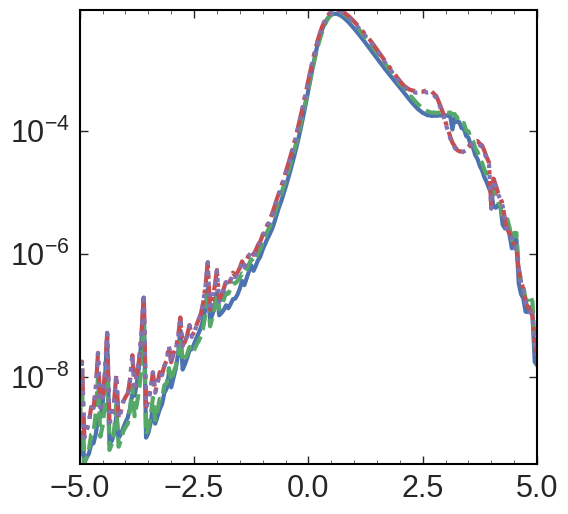

In [154]:
plt.plot(erange_HD, -st0)
plt.plot(erange_HD, -st0_R, ls='--')
plt.plot(erange_HD, -st0_RL, ls='-.')
plt.plot(erange_HD, -st_low, ls=':')
# plt.plot(erange, -ST[:, 0], ls=':')

plt.semilogy()

Is it interpolation or what?

In [155]:
R_resampled = pQ_HD.Rtab[::2,::2]

In [156]:
R_resampled.shape

(101, 26)

In [157]:
erange_res = erange_HD[::2]
qrange_res = qrange_HD[::2]

In [158]:
iR_res = tm.Interpolator2D(ascontiguousarray(qrange_res), ascontiguousarray(erange_res), ascontiguousarray(R_resampled))

In [159]:
st0_res = array([tm.sigma_ff_onshell(z, q, T, iImLT_HD, iR_res, 
                                           iEps1_HD, iEps1_HD) for z in erange_HD])

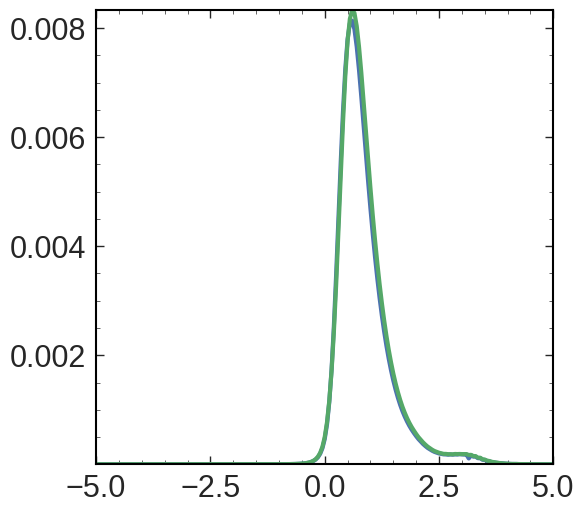

In [162]:
plt.plot(erange_HD, -st0)
plt.plot(erange_HD, -(st0_res - 0*st0))
# plt.plot(erange, -ST[:, 0], ls=':')

# plt.semilogy()

# Quasiparticle pressure comparison

In [163]:
import pandas as pd